## Group 3 - Project 2
# Online Shopper Purchase Prediction

In [ ]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import model as Group3Models
from math import sin, pi
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression

### Read in CSV

In [ ]:
"""Sakar, C. & Kastro, Y. (2018). Online Shoppers Purchasing Intention Dataset [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5F88Q. https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset"""

import model as Group3Models

import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier



In [ ]:
#Read in CSV
online_shopping_df = pd.read_csv('online_shoppers_intention.csv')

online_shopping_df.info()

online_shopping_df["Revenue"].value_counts()

# online_shopping_df.describe()

In [ ]:
online_shopping_df_without_strings = online_shopping_df.copy()
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6, 
          'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
online_shopping_df_without_strings["Month"] = online_shopping_df_without_strings["Month"].map(months)

visitor = {'New_Visitor': 1, 'Returning_Visitor': 2, 'Other': 3}
online_shopping_df_without_strings["VisitorType"] = online_shopping_df_without_strings["VisitorType"].map(visitor)

### Visualize Distributions for EDA

In [ ]:
online_shopping_df.head()

### Split data into training and test sets

In [ ]:
#Drop the target column, setup X and y datasets for train test split
X = online_shopping_df.drop('Revenue', axis=1)
y = online_shopping_df['Revenue']

# Set seed for reproducibility
SEED = 42

#Train Test Split
X_test, X_train, y_test, y_train = train_test_split(X, y, random_state=SEED)

### Scale and Encode Feature Columns

In [ ]:
# Separate numerical and categorical columns
num_cols = ['PageValues', 'BounceRates', 'ExitRates']
cat_cols = ['VisitorType', 'Month']

# Scale numerical columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])  # Fit on training data
X_test[num_cols] = scaler.transform(X_test[num_cols])  # Transform using training data parameters

# One-hot encode categorical columns
X_train = pd.get_dummies(X_train, columns=cat_cols)
X_test = pd.get_dummies(X_test, columns=cat_cols)  # Ensure consistent columns with X_train

# Binary columns (Revenue, Weekend) remain the same


In [ ]:
# # Initialize the OrdinalEncoder and MinMaxScaler
# ordinal_encoder = OrdinalEncoder()
# min_max_scaler = MinMaxScaler()

# #Change Column to values created by encoder and scale them with the min max scaler
# X_train['VisitorType'] = ordinal_encoder.fit_transform(X_train['VisitorType'].values.reshape(-1, 1))
# X_train['VisitorType'] = min_max_scaler.fit_transform(X_train['VisitorType'].values.reshape(-1, 1))

# ordinal_encoder = OrdinalEncoder()
# min_max_scaler = MinMaxScaler()

# X_train['Month'] = X_train['Month'].apply(lambda x: sin(x*(pi * 6)))

# # Fit and transform the 'VisitorType' column with OrdinalEncoder
# X_train['Month'] = ordinal_encoder.fit_transform(X_train['Month'].values.reshape(-1, 1))

# # Now scale the encoded values to [0, 1] using MinMaxScaler
# X_train['Month'] = min_max_scaler.fit_transform(X_train['Month'].values.reshape(-1, 1))

# # Check the unique values after scaling
# print(X_train['Month'].value_counts())

### Use SMOTEEN to oversample and balance the classes

In [ ]:
#SMOTEEN the X_train, y_train to balance the classes
smote = SMOTEENN(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

### Create report on model performances

#### ADABoost_V2

In [ ]:
#Without SMOTEEN
model = Group3Models.ADABoost_V2()
model.fit(X_train, y_train)
Group3Models.evaluate_model(model, X_train, X_test, y_train, y_test)

In [ ]:
model = Group3Models.ADABoost_V2()
model.fit(X_train_bal, y_train_bal)
Group3Models.evaluate_model(model, X_train_bal, X_test, y_train_bal, y_test)

In [ ]:
#Without SMOTEEN
model = Group3Models.ADABoost_V3()
model.fit(X_train, y_train)
Group3Models.evaluate_model(model, X_train, X_test, y_train, y_test)

In [ ]:
model = Group3Models.ADABoost_V3()
model.fit(X_train_bal, y_train_bal)
model.best_estimator_
Group3Models.evaluate_model(model.best_estimator_, X_train_bal, X_test, y_train_bal, y_test)

#### Logistic Regression

In [ ]:
#without SMOTEENN
model = Group3Models.model_logistic_regression_v1(X_train, y_train)
Group3Models.evaluate_model(model, X_train, X_test, y_train, y_test)

In [ ]:
model = Group3Models.model_logistic_regression_v1(X_train_bal, y_train_bal)
Group3Models.evaluate_model(model, X_train_bal, X_test, y_train_bal, y_test)

In [ ]:
#Drop the target column, setup X and y datasets for train test split
X = online_shopping_df.drop('Revenue', axis=1)
y = online_shopping_df['Revenue']

X.head()

#Train Test Split
X_test, X_train, y_test, y_train = train_test_split(X, y)
X_train.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.00000
mean,2.343497,83.106058,0.493351,32.867182,31.343172,1197.885579,0.022662,0.043794,5.635247,0.062147,2.110931,2.315602,3.165099,4.08628
std,3.399204,182.256439,1.344421,144.571383,44.403915,1920.466749,0.048801,0.048665,17.661271,0.200658,0.886861,1.616744,2.416212,3.99566
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,181.183333,0.000000,0.014378,0.000000,0.000000,2.000000,2.000000,1.000000,2.00000
50%,1.000000,6.000000,0.000000,0.000000,17.000000,585.391667,0.003478,0.025901,0.000000,0.000000,2.000000,2.000000,3.000000,2.00000
75%,4.000000,94.920000,0.000000,0.000000,37.000000,1430.552083,0.018182,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.00000
max,26.000000,2629.253968,24.000000,2256.916667,705.000000,43171.233380,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.00000


## Add Encodings to Feature Columns

In [24]:
#Encode VisitorType Column
ordinal_encoder = OrdinalEncoder()
X_train['VisitorType'] = ordinal_encoder.fit_transform(X_train[['VisitorType']])

#Ordinal Encode the Month Column
ordinal_encoder = OrdinalEncoder(categories=[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']])
X_train['Month'] = ordinal_encoder.fit_transform(X_train[['Month']])
X_train.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
2844,11,498.9,3,147.166667,43,1090.060606,0.004082,0.011338,4.759935,0.0,4.0,1,2,4,5,2.0,False
4091,0,0.0,0,0.000000,2,10.000000,0.000000,0.100000,0.000000,0.0,4.0,1,1,1,3,2.0,False
968,0,0.0,0,0.000000,33,3506.166667,0.000000,0.025000,0.000000,0.0,2.0,1,1,1,1,2.0,True
1335,1,3.0,2,373.000000,6,66.833333,0.000000,0.012500,0.000000,0.0,2.0,2,4,1,8,0.0,False
1604,0,0.0,0,0.000000,9,381.000000,0.000000,0.025000,0.000000,0.0,2.0,2,2,6,2,0.0,False


In [25]:
#Encode VisitorType Column
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_test[['VisitorType']])
X_test['VisitorType'] = ordinal_encoder.transform(X_test[['VisitorType']])

#Ordinal Encode the Month Column
ordinal_encoder = OrdinalEncoder(categories=[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']])
X_test['Month'] = ordinal_encoder.fit_transform(X_test[['Month']])

<Axes: >

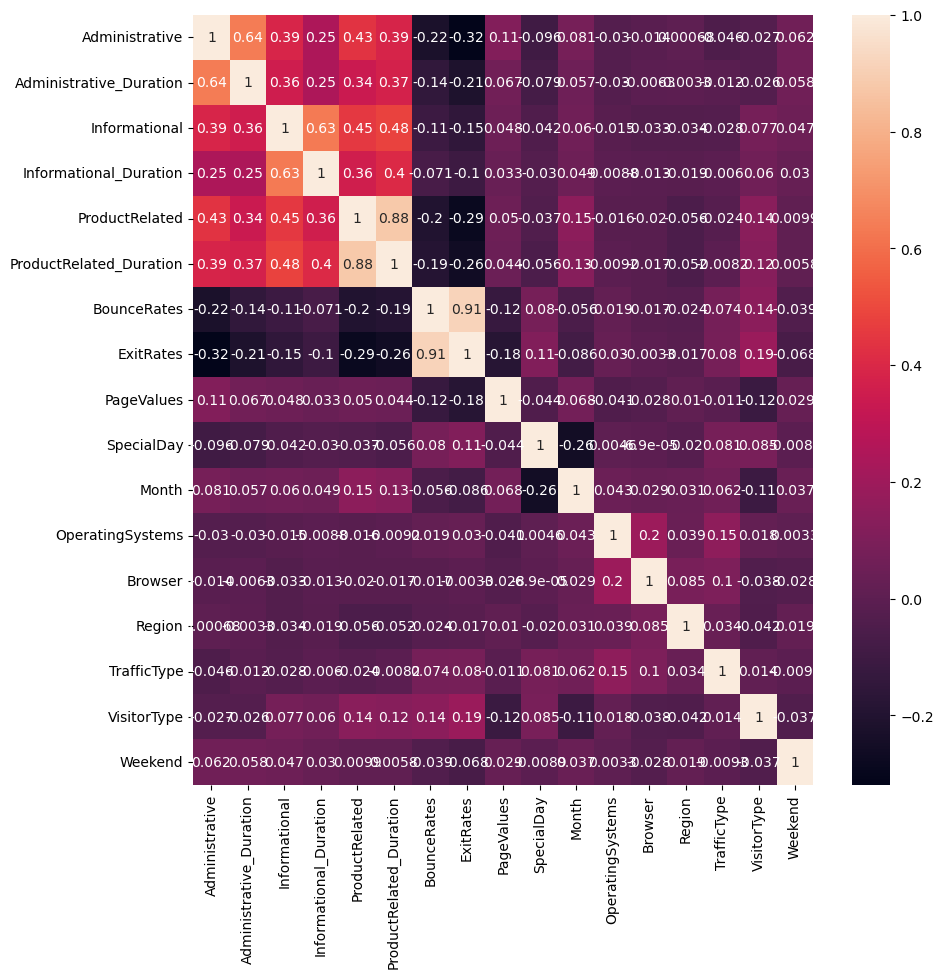

In [26]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=X_train.corr(), annot=True)

## Create a Model and predict

Model Score:  0.8881799502541364
Accuracy Score: 0.8881799502541364
Balanced Accuracy Score: 0.699991636607066
              precision    recall  f1-score   support

       False       0.90      0.97      0.94      7828
        True       0.73      0.43      0.54      1419

    accuracy                           0.89      9247
   macro avg       0.82      0.70      0.74      9247
weighted avg       0.88      0.89      0.88      9247



c:\Users\donal\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


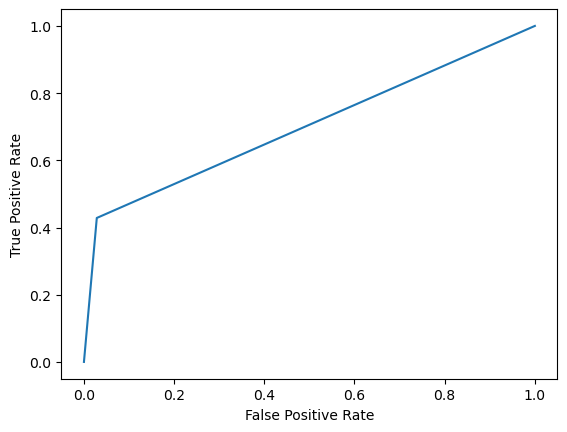

AUC Score: 0.6999916366070661


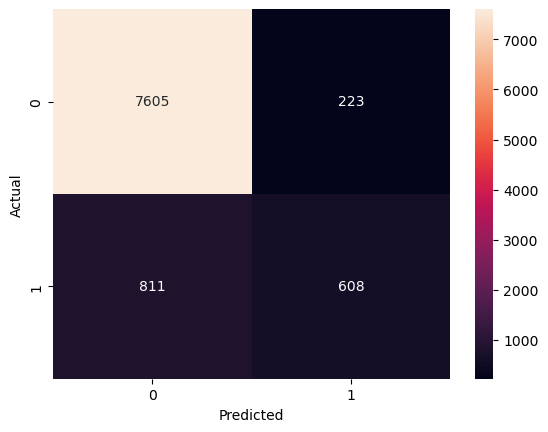

Large gap in score means overfitting: 
0.8819331819656179
0.8881799502541364


AttributeError: 'LogisticRegression' object has no attribute 'best_params_'

In [27]:
#without SMOTEENN
model = Group3Models.model_logistic_regression_v2(X_train, y_train)
Group3Models.evaluate_model(model, X_train, X_test, y_train, y_test)

Model Score:  0.8628744457661944
Accuracy Score: 0.8628744457661944
Balanced Accuracy Score: 0.8088064457002437
              precision    recall  f1-score   support

       False       0.95      0.89      0.92      7828
        True       0.54      0.73      0.62      1419

    accuracy                           0.86      9247
   macro avg       0.74      0.81      0.77      9247
weighted avg       0.89      0.86      0.87      9247



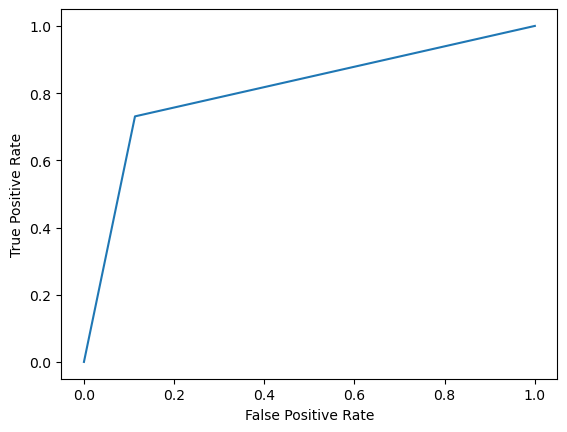

AUC Score: 0.8088064457002437


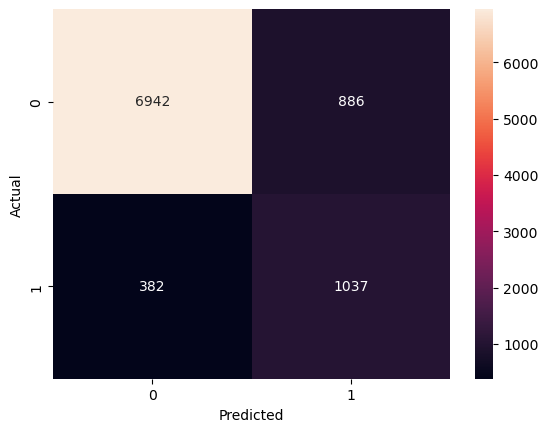

Large gap in score means overfitting: 
0.9471916971916972
0.8628744457661944


In [65]:
model = Group3Models.model_logistic_regression_v2(X_train_bal, y_train_bal)
Group3Models.evaluate_model(model, X_train_bal, X_test, y_train_bal, y_test)

#### Pipeline Logistic Regression

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize data
    ('model', LogisticRegression())  # Train classifier
])

In [ ]:
pipeline.fit(X_train, y_train)
print("Test Accuracy train:", pipeline.score(X_train, y_train))
print("Test Accuracy test:", pipeline.score(X_test, y_test))
